In [1]:
import yaml
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from umap.umap_ import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load YAML data
def load_yaml_articles(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        articles = yaml.safe_load(file)
    return articles


articles = load_yaml_articles('articles.yaml')

In [3]:
from urllib.parse import urlparse
import re

def extract_topics_from_url(url, skip_last_n=2):
    path = urlparse(url).path
    parts = [part for part in path.strip("/").split("/") if part]

    if len(parts) > skip_last_n:
        topics = parts[:-skip_last_n]
    else:
        topics = []

    # Replace hyphens with spaces, remove numbers if needed, clean up
    topics = [re.sub(r'[-_]+', ' ', topic) for topic in topics]

    return topics


In [4]:
# Assuming articles are loaded like this:
# articles = load_yaml_articles('articles.yaml')

for article in articles:
    article['url_topics'] = extract_topics_from_url(article['url'])

# Verify:
print(articles[0]['url_topics'])

['svet', 'preberite tudi']


In [5]:
# Extract representative texts from articles
def get_article_text(article):
    text_parts = [
        article.get('title', ''),
        article.get('lead', ''),
        ' '.join(article.get('paragraphs', [])),
    ]
    return ' '.join(text_parts)
    
# Prepare data
texts = [get_article_text(article) for article in tqdm(articles, desc="Processing articles")]


Processing articles: 100%|██████████| 29493/29493 [00:00<00:00, 86676.07it/s] 


In [41]:
# ----------- TF-IDF Embeddings ----------- #
print("Generating TF-IDF embeddings...")
tfidf_vectorizer = TfidfVectorizer(
        max_features=20000,  # Increased for large dataset
        min_df=10,  # Ignore terms in fewer than 10 documents
        max_df=0.85,  # Ignore terms in more than 85% of documents
        ngram_range=(1, 2),  # Include both words and two-word phrases
    )
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

Generating TF-IDF embeddings...


In [53]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# TODO: report
# tfidf_dense = tfidf_matrix.toarray()

# # Reduce dimensionality to something manageable (e.g. 50D)
# pca = PCA(n_components=50, random_state=42)
# tfidf_pca = pca.fit_transform(tfidf_dense)

svd = TruncatedSVD(n_components=15, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100, random_state=42)
#tfidf_tsne_2d = tsne.fit_transform(tfidf_reduced)
tfidf_tsne_2d = tsne.fit_transform(tfidf_reduced)

### FILL EVERYTHING

In [9]:
import umap

# umap_50d = umap.UMAP(n_components=50, metric='cosine', random_state=42).fit_transform(tfidf_matrix)
#umap_2d = umap.UMAP(n_components=2, metric='cosine', random_state=42).fit_transform(tfidf_matrix)

In [10]:
#np.save("tfidf_umap_2d.npy", umap_2d)
umap_2d = np.load("tfidf_umap_2d.npy")

In [51]:
# np.save("tfidf_umap50d.npy", umap_50d)
umap_50d = np.load("tfidf_umap50d.npy")

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


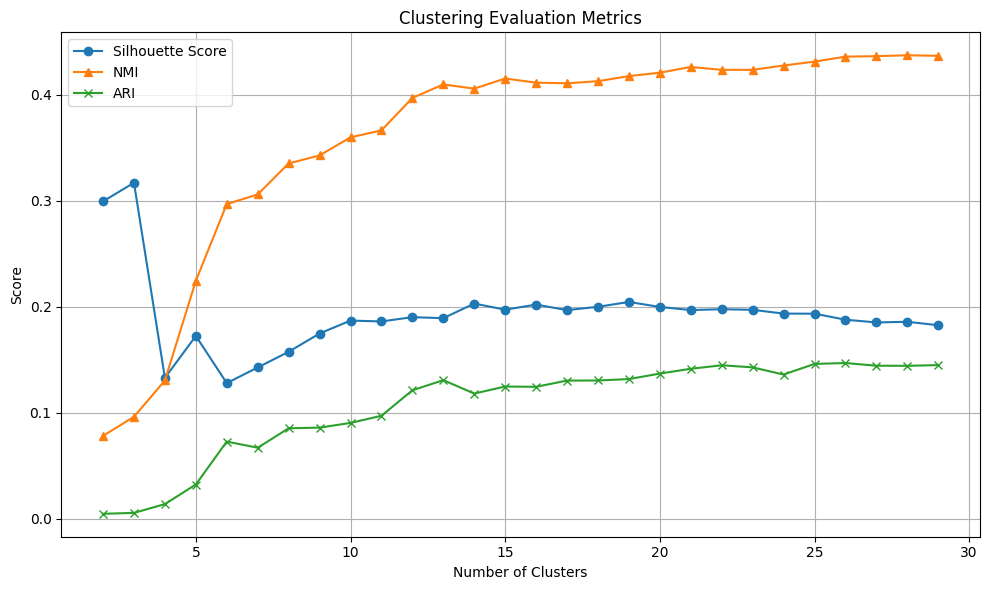

In [54]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt


def cluster_with_kmeans(embeddings, n_clusters=20, random_state=42):
    """
    Clusters the given embeddings using KMeans.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features)
        n_clusters (int): Number of clusters to create
        random_state (int): For reproducibility

    Returns:
        clusters (np.ndarray): Cluster labels for each item
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    clusters = kmeans.fit_predict(embeddings)
    return clusters

# Example usage
tfidf_clusters = cluster_with_kmeans(tfidf_reduced, n_clusters=10)

topic_strings = [
    "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]
le = LabelEncoder()
topic_labels = le.fit_transform(topic_strings)

# Evaluate clustering
def draw_graph():
    ari_score = []
    nmi_score = []
    silhouette = []
    chz = []

    for n in range(2, 30):
        tfidf_clusters = cluster_with_kmeans(tfidf_reduced, n_clusters=n)

        ari_score.append(adjusted_rand_score(topic_labels, tfidf_clusters))
        nmi_score.append(normalized_mutual_info_score(topic_labels, tfidf_clusters))
        silhouette.append(silhouette_score(tfidf_reduced, tfidf_clusters))
        #chz.append(calinski_harabasz_score(umap_25d, sbert_clusters))
        print(n)
    
    plt.figure(figsize=(10, 6))

    x = list(range(2, 30))
    plt.plot(x, silhouette, label='Silhouette Score', marker='o')
    #plt.plot(x, chz, label='Calinski-Harabasz', marker='s')
    plt.plot(x, nmi_score, label='NMI', marker='^')
    plt.plot(x, ari_score, label='ARI', marker='x')

    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    plt.title("Clustering Evaluation Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

draw_graph()

In [38]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import alphashape
from shapely.geometry import Polygon, MultiPolygon
import plotly.colors as pc
from itertools import cycle

def add_alpha_shape_outline(fig, points, group_label, alpha=0.2, opacity=0.1):
    try:
        shape = alphashape.alphashape(points, alpha)
        if shape is None:
            return
        if isinstance(shape, Polygon):
            polygons = [shape]
        elif isinstance(shape, MultiPolygon):
            polygons = list(shape.geoms)
        else:
            return

        for poly in polygons:
            x = list(poly.exterior.coords.xy[0])
            y = list(poly.exterior.coords.xy[1])

            fig.add_trace(
                go.Scattergl(
                    x=x,
                    y=y,
                    mode='lines',
                    line=dict(color='black', width=1, dash='dot'),
                    fill='toself',
                    fillcolor=f'rgba(0,0,0,{opacity})',
                    name=group_label,
                    legendgroup=group_label,
                    hoverinfo='text',
                    text=[group_label] * len(x),
                    showlegend=False
                )
            )
    except Exception as e:
        print(f"⚠️ Could not draw outline for group '{group_label}': {e}")

def draw_single_plot(
    umap_embeddings,
    clusters,
    titles,
    categories=None,
    rename_map=None,
    show_group_outlines=True,
    outline_opacity=0.05,
    alpha=5,
    title="2D Cluster Visualization"
):
    df = pd.DataFrame({
        'x': umap_embeddings[:, 0],
        'y': umap_embeddings[:, 1],
        'cluster': clusters.astype(str),
        'title': titles,
    })

    color_pool = (
        pc.qualitative.Plotly +
        pc.qualitative.D3 +
        pc.qualitative.Set1 +
        pc.qualitative.Set2 +
        pc.qualitative.Set3 +
        pc.qualitative.Pastel1 +
        pc.qualitative.Pastel2 +
        pc.qualitative.Dark24 +
        pc.qualitative.Alphabet
    )
    color_cycle = cycle(color_pool)

    if rename_map:
        df['group'] = [rename_map.get(int(c), "Other / Noise")[:20] for c in clusters]
    elif categories is not None:
        df['group'] = pd.Series(categories).astype(str)
    else:
        df['group'] = df['cluster']

    unique_groups = sorted(df['group'].unique())
    group_to_color = {group: next(color_cycle) for group in unique_groups}

    fig = go.Figure()

    for group in unique_groups:
        sub_df = df[df['group'] == group]
        fig.add_trace(
            go.Scattergl(
                x=sub_df['x'],
                y=sub_df['y'],
                mode='markers',
                name=group,
                marker=dict(size=4, color=group_to_color[group]),
                legendgroup=group,
                showlegend=True,
                hoverinfo='skip',
            )
        )

        if show_group_outlines and len(sub_df) >= 3:
            points = sub_df[['x', 'y']].to_numpy(dtype=np.float32)
            add_alpha_shape_outline(fig, points, group, alpha=alpha, opacity=outline_opacity)

    fig.update_layout(
        title=title,
        width=1200,
        height=800,
        xaxis_title="UMAP 1",
        yaxis_title="UMAP 2",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.25,
            xanchor="center",
            x=0.5,
            title=None,
            font=dict(size=10)
        ),
        margin=dict(t=80, b=120)
    )

    fig.show()


In [15]:
print(len(set(tfidf_clusters)))

27


In [16]:
import json

def load_combined_jsonl(filename="preprocessed_combined.jsonl"):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

# Example usage
preprocessed_texts = load_combined_jsonl()
print(f"✅ Loaded {len(preprocessed_texts)} preprocessed articles.")


✅ Loaded 29493 preprocessed articles.


In [17]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# You should pass in a stopword list — ideally Slovene
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

# Setup stopwords & lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('slovene'))
def extract_cluster_keywords(texts, clusters, stop_words=list(stop_words), top_n=20, ngram_range=(1, 2)):
    """
    Extracts top n-grams (unigrams + bigrams) from preprocessed texts by cluster.
    """
    unique_clusters = np.unique(clusters[clusters >= 0])
    keywords_per_cluster = {}

    for cluster_label in unique_clusters:
        # cluster_texts = [texts[i] for i in range(len(texts)) if clusters[i] == cluster_label]
        # if not cluster_texts:
        #     continue
        cluster_texts = [preprocessed_texts[i] for i in range(len(texts)) if clusters[i] == cluster_label]
        cluster_titles = [articles[i]['title'] for i in range(len(texts)) if clusters[i] == cluster_label]
        if not cluster_texts:
            continue

        # TF-IDF with stopword filtering and n-grams
        vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words=stop_words,
            ngram_range=ngram_range,
            token_pattern=r'\b\w{3,}\b',  # only tokens with 3+ letters
        )
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

        # Top N terms by TF-IDF score
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_keywords = feature_array[top_indices]

        keywords_per_cluster[cluster_label] = list(top_keywords)
        print(f"🧠 Cluster {cluster_label} → {', '.join(top_keywords)}")
        for i in range(len(cluster_titles[:5])):
            print("----", cluster_titles[i])

    return keywords_per_cluster

# Label from keywords
def keywords_to_sentence(keywords, lang='sl'):
    if not keywords:
        return "Drugo / Brez teme" if lang == 'sl' else "Other / No topic"

    if len(keywords) == 1:
        return f"Tematika: {keywords[0]}" if lang == 'sl' else f"Topic: {keywords[0]}"

    limit = 0
    body = ", ".join(keywords[:-1-limit]) + f" in {keywords[-1-limit]}"
    return (
        f"{body}" if lang == 'sl'
        else f"{body}"
    )



[nltk_data] Downloading package punkt to /Users/matjeez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matjeez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/matjeez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
# categories = [
#     article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
#     for article in articles
# ]
# categories = [
#     article['topics'] for article in articles
# ]
# categories = [
#     "/".join(article['url_topics'][:2]) if article['url_topics'] else "no-topic"
#     for article in articles
# ]

from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Clusters", "Categories"))

#outliers = detect_2d_outliers(sbert_umap, generalized_topic_labels, max_percentile=80)

# Filter or annotate
# filtered_points = ~outliers
# titles_filtered = np.array([article['title'] for article in articles])[filtered_points]
# clusters_filtered = np.array(sbert_clusters)[filtered_points]
# categories_filtered = np.array(generalized_topic_labels)[filtered_points]
# sbert_umap_filtered = sbert_umap[filtered_points]


# 1. Extract keywords per cluster
keywords_per_cluster = extract_cluster_keywords(texts, tfidf_clusters)

# 2. Summarize them
cluster_name_map = {
    cluster_id: keywords_to_sentence(keywords)  # or keywords_to_summary()
    for cluster_id, keywords in keywords_per_cluster.items()
}
# Left: Clusters
draw_single_plot( umap_embeddings=tfidf_tsne_2d,
            #umap_embeddings=umap_2d,
            clusters=tfidf_clusters,
            titles=[article['title'] for article in articles],
            rename_map=cluster_name_map,#cluster_name_map,
            show_group_outlines=False)

# Right: Categories
# draw_points(fig, "Categories", col=2, 
#             umap_embeddings=tfidf_tsne_2d,
#             #umap_embeddings=tsne_2d,
#             clusters=tfidf_clusters,  # still required for shape
#             titles=[article['title'] for article in articles],
#             categories=categories,
#             show_group_outlines=False)
# draw_points(fig, "Clusters", col=2, 
#             umap_embeddings=sbert_umap,
#             #umap_embeddings=tsne_2d,
#             clusters=sbert_clusters,
#             titles=[article['title'] for article in articles],
#             categories=None,
#             show_group_outlines=True)

fig.update_layout(
    height=500,
    width=1000,
    title_text="Clusters vs. Categories",
    legend_title_text="Legend",
)

fig.show()


🧠 Cluster 0 → izraelski, gaza, izrael, napad, hamas, človek, vojska, palestinski, libanon, izraelski vojska, ubit, pomoč, območje, dogovor, humanitaren, libanonski, talec, sila, palestinec, prekinitev
---- Izrael vse glasneje o selitvi Palestincev iz Gaze. Oblasti skrbi obtožba zaradi genocida.
---- V Libanonu ubit namestnik vodje Hamasa. Izrael bo na ICJ-ju izpodbijal obtožbe genocida.
---- Ugledne izraelske javne osebnosti obsodile "hujskanje h genocidu"
---- Atentat na drugega moža Hamasa v Bejrutu: vodja Hezbolaha zagrozil Izraelu
---- ZDA: Tožba Južne Afrike zoper Izrael zaradi očitkov o genocidu kontraproduktivna
🧠 Cluster 1 → trump, leto, stranka, volitev, država, predsednik, vlada, zda, ameriški, nov, sodišče, evropski, ukrajina, ruski, napad, nekdanji, velik, človek, parlament, odstotek
---- Skupina BRICS odslej z novimi polnopravnimi članicami
---- Papež pri novoletni maši poudaril pomen žensk za mir na svetu
---- Vplivni in bogati v strahu pred objavo 180 imen, povezanih z E

In [23]:
np.save("tfidf_clusters.npy", tfidf_clusters)
np.save("true_labels.npy", categories)